# Principle of univariance

In [1]:
import dreye
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
wls = np.arange(300, 651)

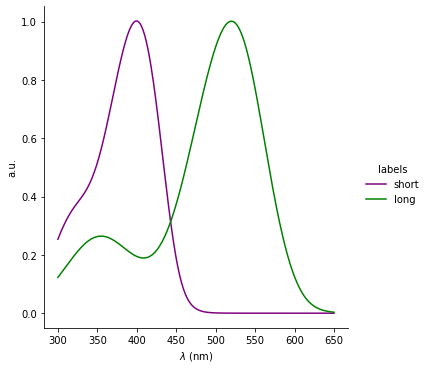

In [3]:
cmap = {'short': 'purple', 'long': 'green'}

sensitivity = dreye.Sensitivity(
    np.array([400, 520]), 
    wls, 
    from_template=True, 
    labels=list(cmap)
)
sensitivity.plot(palette=cmap)

In [4]:
pr_model = dreye.LinearPhotoreceptor(sensitivity)

In [5]:
pr_model

LinearPhotoreceptor('short', 'long')

In [6]:
def create_square_lights(wl_ranges):
    square_lights = np.zeros(wls.shape + (len(wl_ranges),))
    for idx, (lower, upper) in enumerate(wl_ranges):
        square_lights[(wls > lower) & (wls < upper), idx] = 1

    square_lights = dreye.IntensitySpectra(
        square_lights, wls, 
        labels=wl_ranges
    )
    return square_lights

In [7]:
wl_ranges = [(350, 410), (430, 490), (510, 580)]
square_lights = create_square_lights(wl_ranges)

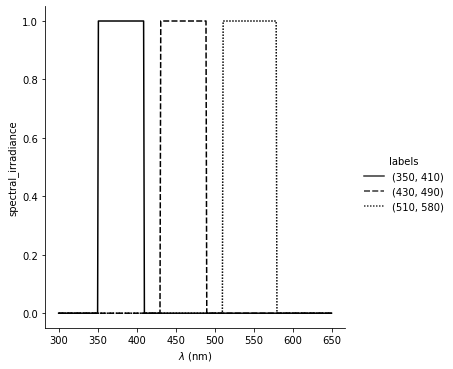

In [8]:
square_lights.plot(hue=None, style='labels', color='black')

In [9]:
def create_q_df(X, columns, index):
    q = pd.DataFrame(X, columns=columns, index=index)
    q.columns.name = 'opsin'
    q.index.name = 'lights'
    q = q.stack()
    q.name = 'capture'
    q = q.reset_index()
    return q

In [10]:
X = pr_model.excitation(square_lights, return_units=False)
q = create_q_df(X, pr_model.labels, pd.Index(square_lights.labels))
q

,lights,opsin,capture
0,"(350, 410)",short,48.815963
1,"(350, 410)",long,13.555221
2,"(430, 490)",short,9.287634
3,"(430, 490)",long,29.068630
4,"(510, 580)",short,0.002994
5,"(510, 580)",long,53.262853


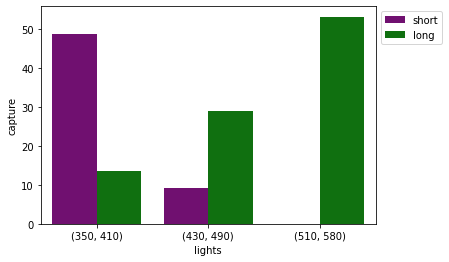

In [11]:
sns.barplot(
    x='lights', 
    y='capture',
    hue='opsin',
    data=q, 
    palette=cmap
)
plt.legend(bbox_to_anchor=(1,1))

In [12]:
measured_spectra = dreye.create_measured_spectra_container([430, 540], names=['cyan', 'lime'])

In [13]:
led_cmap = dict(zip(measured_spectra.names, ['cyan', 'lime']))

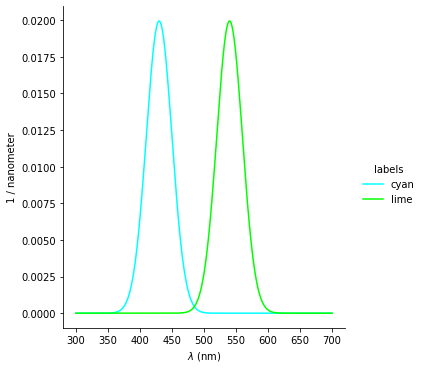

In [14]:
measured_spectra.normalized_spectra.plot(palette=led_cmap)

In [15]:
df1 = sensitivity.to_longframe()
df1['color'] = df1['labels']
df1['style'] = 'nan1'
df1['type'] = 'opsin'
df2 = square_lights.to_longframe()
df2['color'] = 'light'
df2['style'] = df2['labels']
df2['type'] = 'light'
df3 = measured_spectra.normalized_spectra.max_normalized.to_longframe()
df3['color'] = df3['labels']
df3['style'] = 'nan2'
df3['type'] = 'led'

spectra = pd.concat([df1, df3, df2])

In [16]:
def plot_spectra(df):
    sns.lineplot(
        data=df, 
        x='domain', 
        y='values', 
        ci=None, 
        hue='color', 
        palette={
            **cmap, 
            **{'light': 'black', 'led': 'gray'},
            **led_cmap
        }, 
        style='style',
        units='labels', 
        estimator=None
    )
    plt.legend(bbox_to_anchor=(1,1))

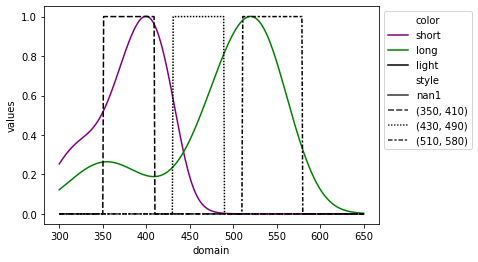

In [17]:
plot_spectra(spectra[spectra['type'].isin(['opsin', 'light'])])

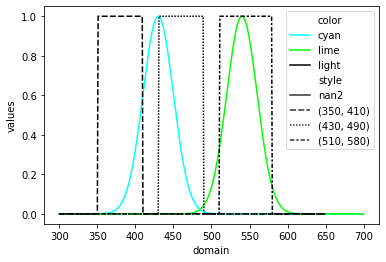

In [18]:
plot_spectra(spectra[spectra['type'].isin(['led', 'light'])])

In [19]:
model = dreye.IndependentExcitationFit(
    photoreceptor_model=pr_model, 
    measured_spectra=measured_spectra, 
    ignore_bounds=True
)

In [20]:
model.fit(X)

IndependentExcitationFit(ignore_bounds=True,
                         measured_spectra=MeasuredSpectraContainer([[0.0 1.4830870082612795e-10 2.966174016522559e-10 ...  1.0381609057828957e-09 1.1864696066090236e-09 1.3347783074351517e-09] [0.0 1.7442300599120065e-10 3.488460119824013e-10 ...  1.2209610419384045e-09 1.3953840479296052e-09 1.569807053920806e-09] [0.0 2.0500736757072765e-10 4.10...3.3456387951248854e-14 3.763843644515497e-14] [0.0 3.427183191450562e-15 6.854366382901124e-15 ...  2.3990282340153935e-14 2.7417465531604498e-14 3.084464872305506e-14] [0.0 2.806817268631609e-15 5.613634537263218e-15 ...  1.964772088042126e-14 2.2454538149052872e-14 2.5261355417684482e-14]] microspectral_E_Q),
                         photoreceptor_model=LinearPhotoreceptor('short', 'long'))

In [29]:
fitted_spectra = measured_spectra.ints_to_spectra(
    model.fitted_intensities_
)
fitted_spectra.labels = square_lights.labels

In [32]:
df4 = fitted_spectra.to_longframe()
df4['color'] = 'led'
df4['style'] = df4['labels']
df4['type'] = 'simulated'

df4 = pd.concat([df2, df4])

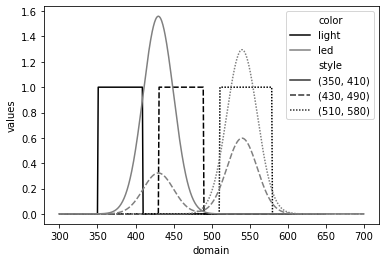

In [34]:
plot_spectra(df4)

In [28]:
model.sample_scores()

array([0.86708372, 1.        , 0.99999998])

In [30]:
fitted_q = create_q_df(model.fitted_excite_X_, pr_model.labels, pd.Index(square_lights.labels))
q['light'] = 'square light'
fitted_q['light'] = 'led combination'
Q = pd.concat([q, fitted_q])

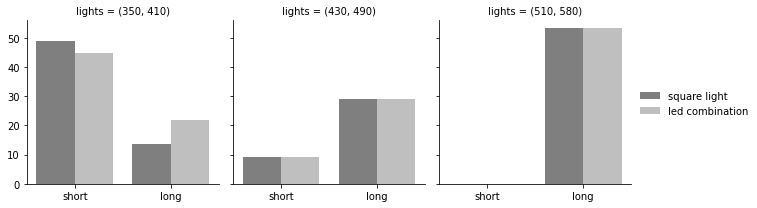

In [31]:
g = sns.FacetGrid(
    data=Q, 
    col='lights', 
)
g.map_dataframe(
    sns.barplot, x="opsin", y="capture", 
    hue="light", palette={
        'square light': 'black', 
        'led combination': 'gray'
    }, 
    alpha=0.5
).add_legend()